In [16]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import librosa
import random
import shutil
import os

from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from pydub import AudioSegment
from PIL import Image

<H1>Original Dataset</H1>

In [2]:
#Load dataset into training/validation/testing at 80-10-10

train_dir = "original_dataset/training/"
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size = (515, 389), color_mode = "rgb", class_mode = 'categorical', batch_size = 32, seed = 767)

validation_dir = "original_dataset/validation/"
vali_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir, target_size = (515, 389), color_mode = 'rgb', class_mode = 'categorical', batch_size = 32, seed = 767)

testing_dir = "original_dataset/testing/"
testing_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
testing_generator = vali_datagen.flow_from_directory(testing_dir, target_size = (515, 389), color_mode = 'rgb', class_mode = 'categorical', shuffle = False, batch_size = 32, seed = 767)

Found 7200 images belonging to 9 classes.
Found 900 images belonging to 9 classes.
Found 900 images belonging to 9 classes.


<H1>Custom Dataset (+ Rap, Brazilian Funk)</H1>

In [45]:
#Load dataset into training/validation/testing at 80-10-10

train_dir = "custom_dataset/training/"
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size = (515, 389), color_mode = "rgb", class_mode = 'categorical', batch_size = 32, seed = 767)

validation_dir = "custom_dataset/validation/"
vali_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir, target_size = (515, 389), color_mode = 'rgb', class_mode = 'categorical', batch_size = 32, seed = 767)

testing_dir = "custom_dataset/testing/"
testing_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
testing_generator = vali_datagen.flow_from_directory(testing_dir, target_size = (515, 389), color_mode = 'rgb', class_mode = 'categorical', shuffle = False, batch_size = 32, seed = 767)

Found 11736 images belonging to 11 classes.
Found 1400 images belonging to 11 classes.
Found 1400 images belonging to 11 classes.


<H1>Custom Functions</H1>

In [46]:
def precision_per_class(model, testing_generator):
    predictions = model.predict(testing_generator)
    y_pred = np.argmax(predictions, axis = 1)
    true_classes = testing_generator.classes
    class_labels = list(testing_generator.class_indices.keys())   
    report = classification_report(true_classes, y_pred, target_names = class_labels)
    print(report)   
    
def multiclass_confusion_matrix(model, testing_generator):
    predictions = model.predict(testing_generator)
    y_pred = np.argmax(predictions, axis = 1)
    true_classes = testing_generator.classes
    class_labels = list(testing_generator.class_indices.keys())   
    report = confusion_matrix(true_classes, y_pred)
    plt.figure(figsize = (12, 9))
    ax = plt.axes()
    plt.tick_params(axis = 'both', which = 'both', labelsize = 10, labelbottom = False, bottom = False, top = True, labeltop = True)
    sns.heatmap(report, linewidths = 1, ax = ax, annot = True, fmt = 'g', cmap = 'Greens', xticklabels = class_labels, yticklabels = class_labels)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_label_position('top')
    
def process_wav(song):
    name, ext = os.path.splitext(song)
    sound = AudioSegment.from_wav(song)
    #Stereo to Mono like original dataset
    sound = sound.set_channels(1)
    #Change Hz to 22050Hz like original dataset
    sound = sound.set_frame_rate(22050)
    sound.export("{0}_resampled.wav".format(name), format = "wav")
    
    song = "{0}_resampled.wav".format(name)
    
    i = 0
    to_return = []
    
    total_duration = len(AudioSegment.from_wav(song))
    
    intervals =  int(total_duration / 3000)
    
    for w in range(0, intervals):
        i = i + 1
        t1 = 3 * (w) * 1000
        t2 = 3 * (w + 1) * 1000
        newAudio = AudioSegment.from_wav(song)
        new = newAudio[t1:t2]
        new.export(str(w) + '.wav', format = "wav")
        to_return.append(str(w) + '.wav')
        
    return to_return, intervals

def generate_spectogram_for_song(song):
    x, sr = librosa.load(song, sr = None)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'log')
    plt.axis('off')
    plt.savefig(song.replace(".wav", ".jpg"), bbox_inches = 'tight')
    plt.cla()
    
    return song.replace(".wav", ".jpg")
    
def test_song(song, model):
    name, ext = os.path.splitext(song)
    to_delete, intervals = process_wav(song)
    files_to_delete = ["{0}_resampled.wav".format(name)]
    files_to_delete = files_to_delete + to_delete
    
    probabilities = np.zeros(11)
    
    images_to_delete = []
    
    for mini_part in files_to_delete:
        spectogram = generate_spectogram_for_song(mini_part)
        images_to_delete.append(spectogram)
        image = Image.open(spectogram)
        im_arr = np.frombuffer(image.tobytes(), dtype = np.uint8)
        im_arr = im_arr.reshape((image.size[0], image.size[1], 3))                                   
        image = im_arr / 255.0  # Normalize pixel values to be between 0 and 1
        image = np.expand_dims(image, axis = 0)
        random_test = image
        y_proba = model.predict(random_test, verbose = 0)
        np.set_printoptions(suppress = True) 
        probabilities = probabilities + y_proba[0]
        
    files_to_delete = files_to_delete + images_to_delete   
    for file_to_delete in files_to_delete:
        os.remove(file_to_delete)
    
    hexadecimal_alphabets = '0123456789ABCDEF'

    colors = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in range(6)]) for i in range(9)]
    
    plt.clf()

    fig = plt.figure(figsize = (10, 5))

    # creating the bar plot
    plt.bar(list(train_generator.class_indices.keys()), probabilities / intervals, color = colors, width = 0.4)

    plt.xlabel("Genres")
    plt.ylabel("Probability")
    plt.title("Model prediction for the song {}".format(song.replace('.wav', '')))
    plt.show()
    
    return probabilities / intervals

def piecewise(epoch, lr):
    if epoch < 5:
        return lr
    elif epoch < 15:
        return lr * 0.5
    elif epoch < 20:
        return lr * 0.5
    else:
        return lr * 0.5

<H1>Model Building</H1>

In [4]:
#To use the original 9 genres model
model = tf.keras.models.load_model("CS767_Final_Model_d9.h5")

Metal device set to: Apple M2 Max


In [47]:
#To use the custom 11 genres model
model = tf.keras.models.load_model("CS767_Final_Model.h5")

In [ ]:
#After many iterations, this is our main model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (3, 3), activation = "relu", input_shape = (515, 389, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(16, (3, 3), activation = "relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation = "relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation = "relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(9, activation = "softmax")
])
callback = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.8, patience = 1)
model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = 0.001), metrics = ["accuracy"])
history = model.fit(train_generator, epochs = 20, validation_data = vali_generator, callbacks = [callback])

In [ ]:
model.summary()

In [ ]:
#We evaluate the model
model.evaluate(testing_generator)

In [ ]:
#We save the model
model.save("CS767_Final_Model_d9.h5")

In [ ]:
#NOTES:
#ResNet50: Not great success huh
#SGD: Bad
#Inverted: Bad
#Dense layers at the end: Bad
#More neurons: Bad

<H1>Precision per Class</H1>

In [48]:
precision_per_class(model, testing_generator)

44/44 [==============================] - 3s 72ms/step
                precision    recall  f1-score   support

         blues       0.87      0.90      0.88       100
brazilian_funk       0.94      0.92      0.93       100
     classical       0.97      0.97      0.97       100
       country       0.78      0.85      0.81       100
         disco       0.87      0.90      0.88       100
        hiphop       0.84      0.77      0.80       100
         metal       0.96      0.89      0.92       100
           pop       0.94      0.82      0.88       100
           rap       0.92      0.98      0.95       400
        reggae       0.81      0.81      0.81       100
          rock       0.73      0.64      0.68       100

      accuracy                           0.88      1400
     macro avg       0.87      0.86      0.87      1400
  weighted avg       0.88      0.88      0.88      1400



44/44 [==============================] - 3s 69ms/step


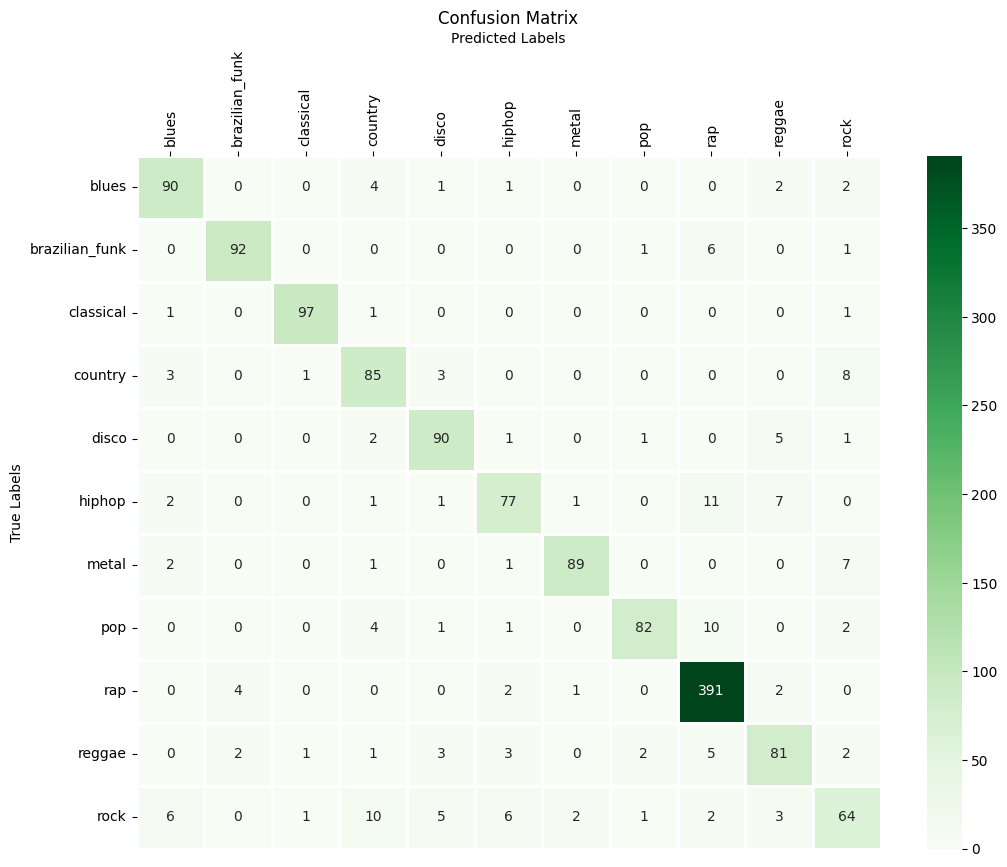

In [49]:
multiclass_confusion_matrix(model, testing_generator)

<H1>Testing Popular Songs</H1>

<Figure size 640x480 with 0 Axes>

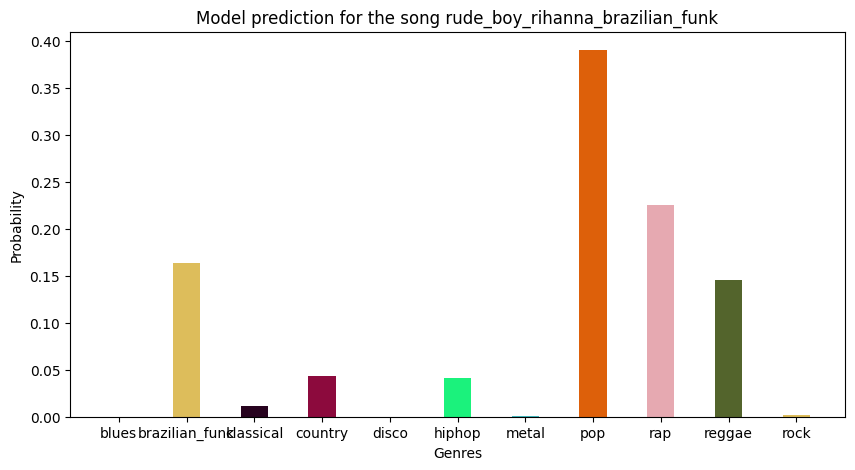

array([0.00000662, 0.16306247, 0.01146385, 0.04346374, 0.00000104,
       0.0411722 , 0.00059412, 0.39053929, 0.22561285, 0.14538389,
       0.0014272 ])

In [50]:
test_song('rude_boy_rihanna_brazilian_funk.wav', model)

<Figure size 640x480 with 0 Axes>

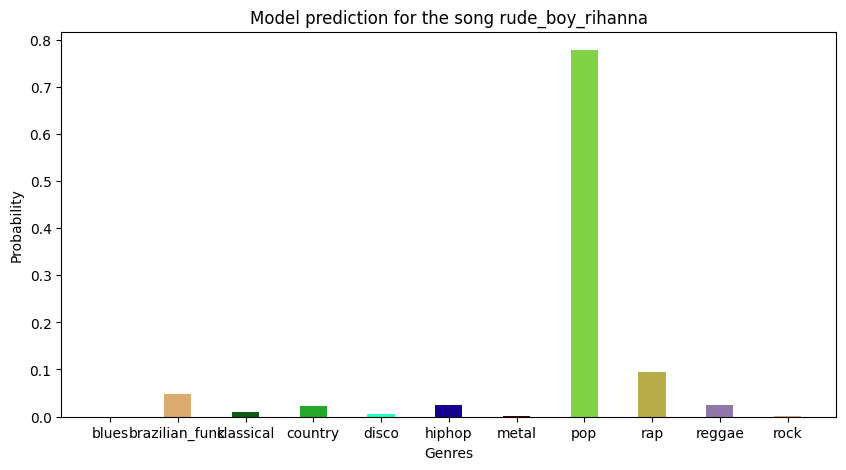

array([0.0001224 , 0.04821271, 0.01044235, 0.02139786, 0.00652767,
       0.02416711, 0.00057712, 0.77815761, 0.09463604, 0.025227  ,
       0.00094882])

In [51]:
test_song('rude_boy_rihanna.wav', model)

<Figure size 640x480 with 0 Axes>

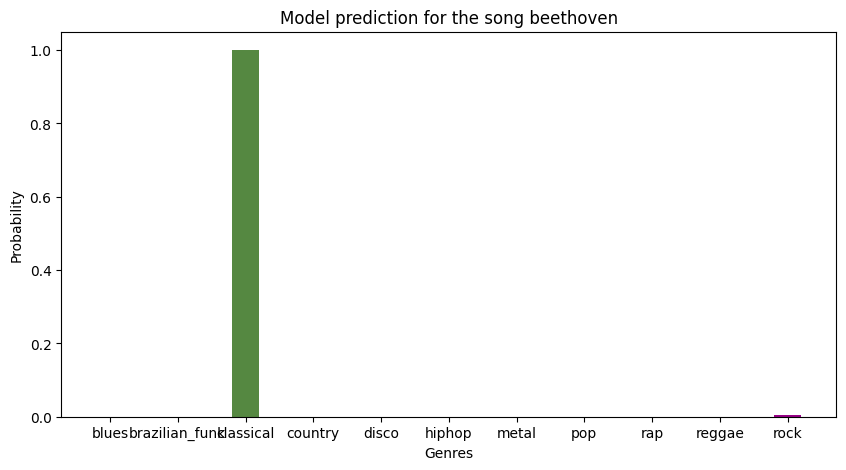

array([0.00000538, 0.00001792, 1.00022761, 0.00009115, 0.        ,
       0.00000001, 0.0000003 , 0.00009146, 0.00000006, 0.        ,
       0.00380341])

In [52]:
test_song('beethoven.wav', model)

<Figure size 640x480 with 0 Axes>

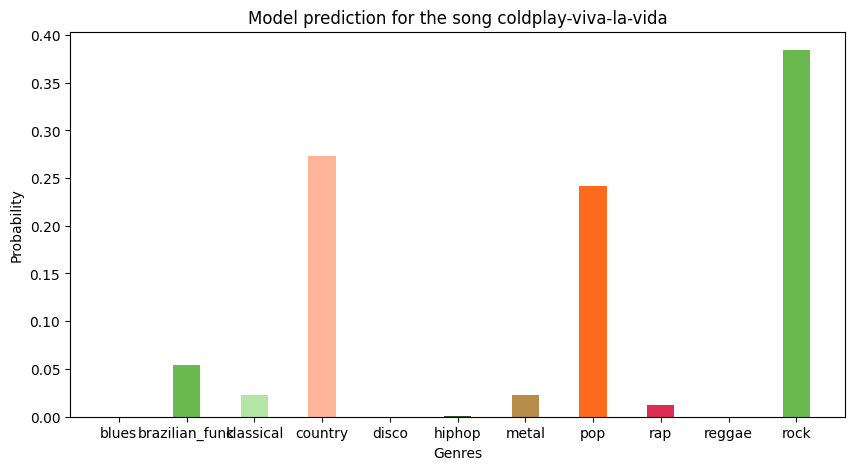

array([0.00000041, 0.05442527, 0.02283116, 0.27273655, 0.00002795,
       0.00056798, 0.02314017, 0.24193249, 0.01243874, 0.00003766,
       0.38436162])

In [53]:
test_song('coldplay-viva-la-vida.wav', model)